In [1]:
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
%config NotebookApp.iopub_msg_rate_limit=10000
import time

In [2]:
songs = pd.read_csv('spotify_songs.csv')

In [38]:
random.seed(6)

def randIdx(testNum, df):
    randIDX = []
    while len(randIDX) <= testNum:
        num = random.randint(0,len(df))
        if not num in randIDX:
            randIDX.append(num)
    return randIDX

testIDX = randIdx(500, songs)
trainIDX = randIdx(500, songs)
        
trainDF = songs.iloc[trainIDX].reset_index(drop=True)
testDF = songs.iloc[testIDX].reset_index(drop=True)

In [39]:
trainDF.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,4VginDwYTP2eaHJzO0QMjG,Circles,Post Malone,49,75n7rjlC1fxezRtoMQmtL5,Circles,2019-08-30,pop,0.704,0.758,0,-3.537,1,0.0402,0.23300,0.001440,0.0924,0.534,120.003,214907
1,3sygLAUhHsJsQ0cBk6fxRd,No,CLC,61,6xSUUpa9LBZYwJFMJOr8M6,No.1,2019-01-30,pop,0.760,0.722,6,-4.429,0,0.0908,0.00785,0.000326,0.1160,0.687,120.055,181976
2,0cGaJCy15wAA1rnExE03Ll,Kulio - Bonus Track,Matroda,39,2I1vC9WZCG47pIFi37kmFn,The RED Tape (Deluxe),2019-08-30,edm,0.804,0.913,11,-3.515,0,0.0681,0.00282,0.151000,0.0589,0.652,124.002,156316
3,0TyJN9PfBK7lecIiMbjWWH,What They Do (feat. BG),T.I.,32,1oFucub5OjyG4XPsDUzhil,Urban Legend,2004-11-29,rap,0.910,0.763,1,-5.275,1,0.2610,0.05630,0.000000,0.0686,0.616,119.979,228720
4,5zdbfjCVtrAUwWeNFsE54s,Deja Vu,Dolla,51,1ZajUXNUXJDN3mhfheC2WB,Deja Vu,2019-09-06,rap,0.739,0.354,1,-13.433,1,0.1410,0.48400,0.000043,0.1180,0.576,98.958,213333


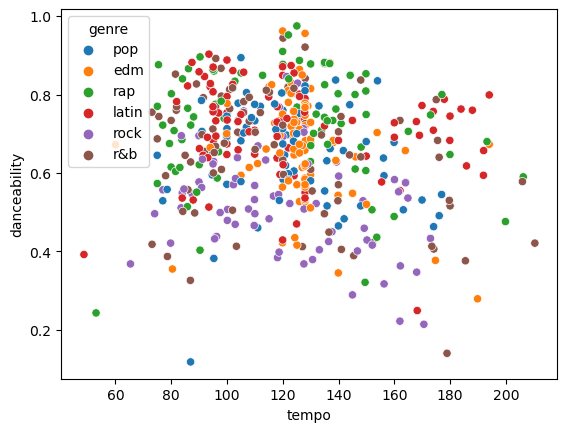

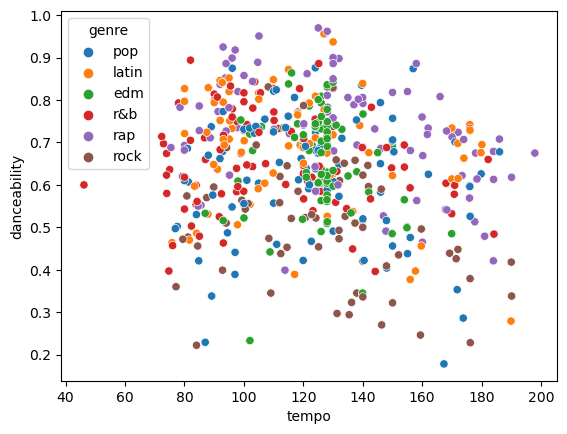

In [40]:
sns.scatterplot(data=trainDF, x='tempo', y='danceability', hue='genre')
plt.show()
sns.scatterplot(data=testDF, x='tempo', y='danceability', hue='genre')
plt.show()

In [31]:
allGenres = songs['genre'].unique()
allGenres

array(['rock', 'r&b', 'pop', 'edm', 'rap', 'latin'], dtype=object)

In [82]:
def knn(df, k, unknown, x, y, current, total):
    allDistances = pd.DataFrame(columns=['distance', 'genre'])
    for i in range(len(df)):
        distance = (((df.loc[i, x] - unknown[x]) ** 2) + ((df.loc[i, y] - unknown[y]) ** 2)) ** 0.5
        locDF = {'distance': [distance], 'genre': [df.loc[i, 'genre']]}
        locDF = pd.DataFrame(locDF)
        allDistances = pd.concat([allDistances, locDF], ignore_index=True)       
        percentDone = round(((i+1)/len(df))*100*(1/total)+((current-1)/total)*100,2)
        clear_output(wait=True)
        time.sleep(0.001)
        print(str(percentDone) + "% done")
    allDistances.sort_values('distance', inplace=True)
    allDistances.reset_index(drop=True, inplace=True)
    kNearest = allDistances.loc[0:k-1]
    #print(allDistances)
    
    counts = []
    for _ in range(len(allGenres)):
        counts.append(0)
    
    for i in range(len(kNearest)):
        for j in range(len(allGenres)):
            #print(str(i), kNearest.loc[i, 'genre'], allGenres[j])
            if kNearest.loc[i, 'genre'] == allGenres[j]:
                counts[j] += 1
                
    #print(counts)
    return allGenres[counts.index(max(counts))]

In [88]:
i = 268
print(knn(trainDF, 9, testDF.iloc[i], 'tempo', 'danceability', 1, 1))
print(testDF.loc[i, 'genre'])

100.0% done
[4, 1, 2, 0, 0, 2]
rock
latin


In [89]:
answers = pd.DataFrame()
for i in range(len(testDF)):
    x = knn(trainDF, 9, testDF.iloc[i], 'tempo', 'danceability', (i+1), len(testDF))
    y = 0
    if x == testDF.loc[i, 'genre']:
        y = 1
    row = pd.DataFrame({'actual': [testDF.loc[i, 'genre']], 'predicted': [x], 'correct': [y]})
    answers = pd.concat([answers, row], ignore_index=True).reset_index(drop=True)

100.0% done
[1, 2, 1, 1, 4, 0]


In [90]:
percentCorrect = round((answers['correct'].sum()/len(answers))*100,2)
percentCorrect

27.54

In [91]:
answers.head(20)

,actual,predicted,correct
0,pop,pop,1
1,latin,latin,1
2,pop,edm,0
3,edm,edm,1
4,pop,edm,0
5,r&b,r&b,1
6,rap,rock,0
7,r&b,latin,0
8,r&b,edm,0
9,rap,r&b,0


In [92]:
unknownGenre = pd.read_csv('unknownGenre.csv')

In [97]:
knn(trainDF, 5, unknownGenre.iloc[0], 'tempo', 'danceability', 1, 1)

100.0% done
[2, 2, 0, 0, 0, 1]


'rock'